# Masked / Causal Attention Implementation

Intro:

Causal attention, also known as masked attention, is a specialized form of self-attention. It restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores. This is in contrast to the standard self-attention mechanism, which allows access to the entire input sequence at once.

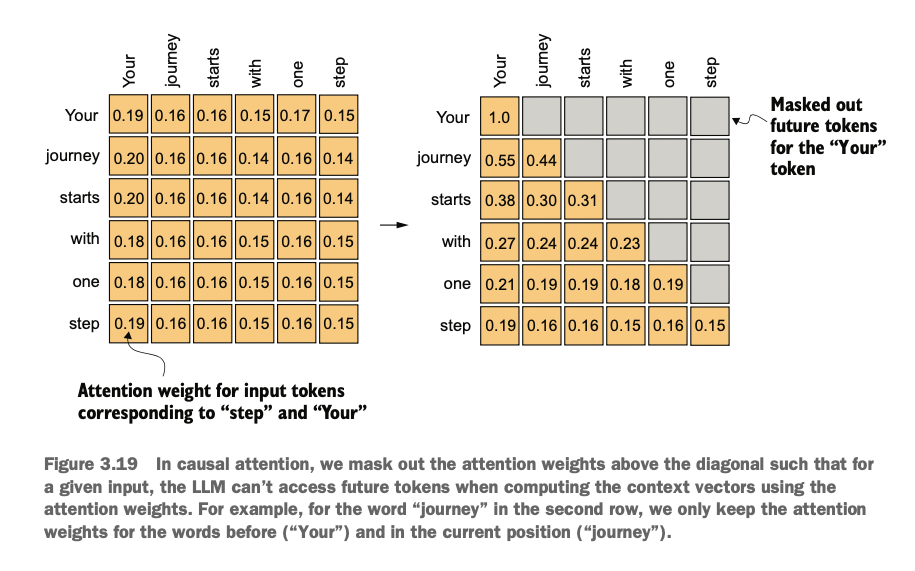

## 1. Applying a causal attention mask

### Step 1: Attention weights

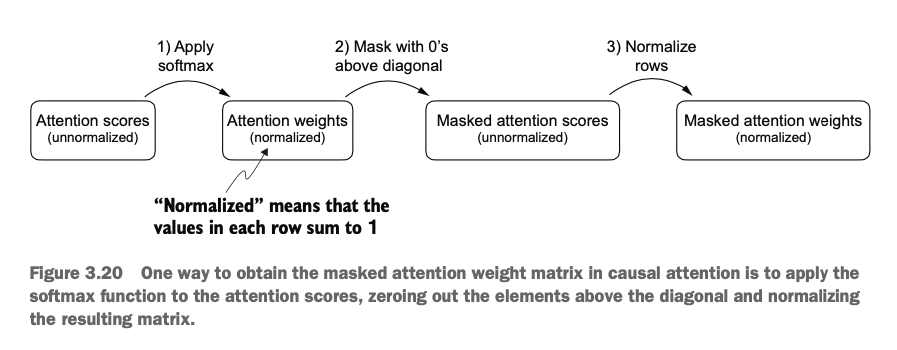

I will bring the attention scores and weights that were calculated from the [self-attention implementation notebook](./implementing%20self-attention.ipynb).

In [1]:
import torch
import torch.nn as nn

torch.manual_seed(789)

inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your     (x^1)
     [0.55, 0.87, 0.66], # journey  (x^2)
     [0.57, 0.85, 0.64], # starts (x^3)
     [0.22, 0.58, 0.33], # with (x^4)
     [0.77, 0.25, 0.10], # one (x^5)
     [0.05, 0.80, 0.55]] # step (x^6)
)

class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = attn_weights @ values
        return context_vec


d_in = inputs.shape[-1]
d_out = 2

sa_v2 = SelfAttention_v2(d_in, d_out)
sa_v2(inputs)

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

In [2]:
###########################################################################################
# Starting the casual attention mask from here

In [3]:
queries = sa_v2.W_query(inputs) # resuing the W_q from sa_v2
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(f'Attention weights:\n{attn_weights}')

Attention weights:
tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


---
### Step 2: Creating the Mask
using PyTorch's `tril` function to create a mask where the values above the diagonal are zero

torch.tril documentation: https://pytorch.org/docs/stable/generated/torch.tril.html

In [4]:
attn_scores.shape

torch.Size([6, 6])

In [5]:
context_length = attn_scores.shape[0]

mask_simple = torch.tril(torch.ones(context_length, context_length))
mask_simple, mask_simple.shape

(tensor([[1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1.]]),
 torch.Size([6, 6]))

In [6]:
# now multiplying this mask with the attention weights to zero-out the values above the diagonal

masked_simple = attn_weights * mask_simple
masked_simple

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)

---
### Step 3: Renormalizing the Attention weights to sum up to 1 again

In [7]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
row_sums

tensor([[0.1921],
        [0.3700],
        [0.5357],
        [0.6775],
        [0.8415],
        [1.0000]], grad_fn=<SumBackward1>)

In [8]:
masked_simple_norm = masked_simple / row_sums
masked_simple_norm

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)

---
---

## 2. Computing the Masked Attention weights more efficiently

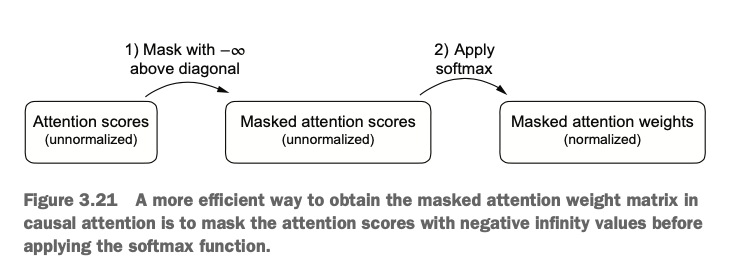

### Step 1: Creating the mask

softmax's formula is: 

$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

where $x_i$ is the $i$-th element of the input tensor $x$ and $n$ is the number of elements in the input tensor $x$. $j$ is the index of the element in the input tensor $x$.

This means that when negative infinity values (-∞) are present in a row, the softmax function treats them as zero probability. Also mathematically, $e^{-∞}$ is 0 (see below), so it automatically points to a zero probability.

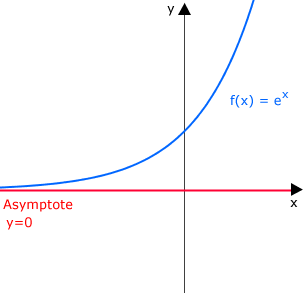

In [9]:
# creating a mask with 1s above the diagonal
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
# diagonal = 1 shifts the 1s 1 diagonal above

print(f'''{mask}\n
{mask.bool()}''')

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])


In [10]:
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
masked, masked.shape

(tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
         [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
         [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
         [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
         [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
         [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
        grad_fn=<MaskedFillBackward0>),
 torch.Size([6, 6]))

#### ↑ Note to myself:
This is making use of the attention scores and NOT the attention weights like before. Not to get things mixed up.

Also, `Tensor.masked_fill_(mask, value)`: Fills elements of `self` tensor with value where `mask` is True. The shape of mask must be broadcastable with the shape of the underlying tensor.

documentation: https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_

---
### Step 2: Creating the masked attention weights

In [11]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)

#### Step 2.1: Masking additional attention weights with dropout
*(would normally be the context vector computation but firstly doing this)*

this is to reduce the overfitting while traininng LLMs.

> [!NOTE] From Raschka's LLM from Scratch Book:\
> Dropout in deep learning is a technique where randomly selected hidden layer units are ignored during training, effectively “dropping” them out. This method helps prevent overfitting by ensuring that a model does not become overly reliant on any specific set of hidden layer units. It’s important to emphasize that **dropout is only used during training and is disabled afterward**.

Here, I will apply the dropout mask after computing the attention weights, as illustrated in figure 3.22 (it’s the more common variant in practice).

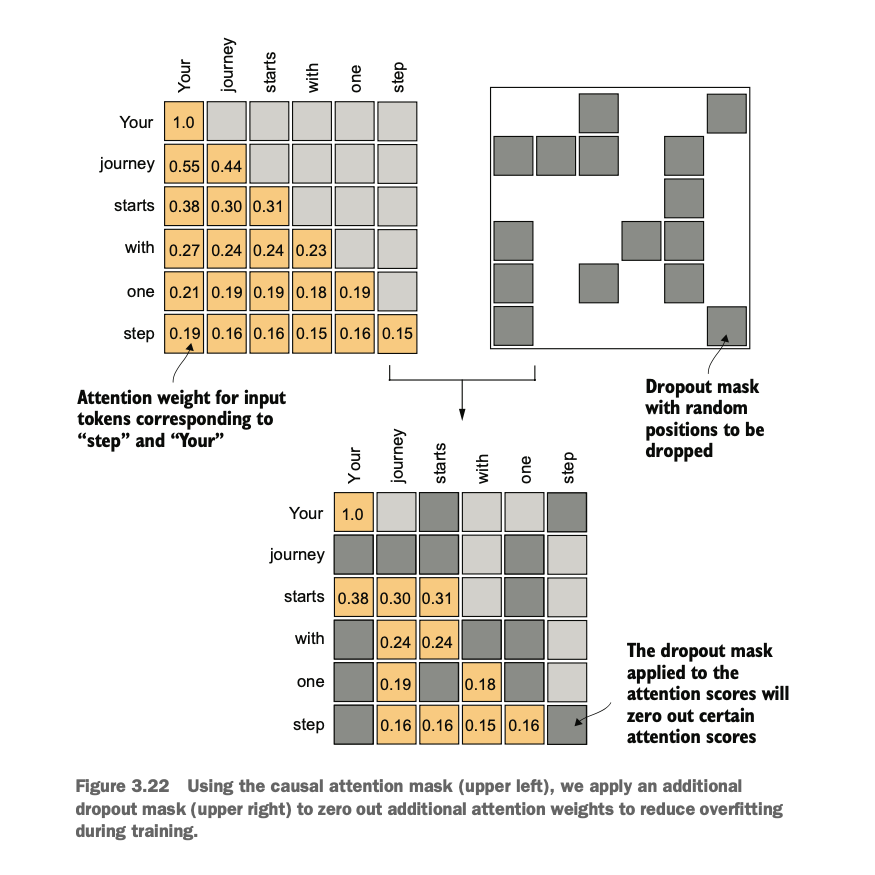

In [12]:
torch.manual_seed(123)
dropout = nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6,6)
print(f'''Example:
{example}

Dropout:
{dropout(example)}''')

Example:
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Dropout:
tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


#### ↑ 2s?
since the dropout is 50%, to compensate for this reduction in active values, the remaining values get scaled up by a factor of 2.

The above was an example. Applying dropout to the attention weight matrix now.

In [13]:
torch.manual_seed(123)
dropout(attn_weights)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

---
---
## Finally: Implementing a Compact Causal Attention Class

torch.stack concatenates a sequence of tensors along a new dimension.

documentation: https://pytorch.org/docs/stable/generated/torch.stack.html 

In [14]:
inputs.shape

torch.Size([6, 3])

In [15]:
batch = torch.stack((inputs, inputs), dim=0)
print(f'{batch}\n=====\n{batch.shape}') # 2 batches

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])
=====
torch.Size([2, 6, 3])


#### ↑ This is resulting in a three-dimensional tensor consisting of two input texts (batch size) with six tokens each, where each token is a three-dimensional embedding vector.
---

> [!NOTE]
> register_buffer (from Raschka's LLM from scratch book): The use of register_buffer in PyTorch is not strictly necessary for all use cases but offers several advantages here. For instance, when we use the CausalAttention class in our LLM, buffers are automati- cally moved to the appropriate device (CPU or GPU) along with our model, which will be relevant when training our LLM. This means we don’t need to manually ensure these tensors are on the same device as your model parameters, avoiding device mis- match errors.

documentation: https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_buffer

In [16]:
# implementation of the causal attention class

class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
    def forward(self, x):
        # the following is just destructuring x (batch in my case) into these 3 things in order -> 2, 6, 3.
        b, num_tokens, d_in = x.shape
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        # in the following, keys.transpose(1, 2) changes keys from [2, 6, 2] to [2, 2, 6], swapping
        # the token and embedding dimensions. This transposition allows matrix multiplication between
        # queries and keys along the last dimension of queries and the second-to-last dimension of keys.
        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        
        context_vec = attn_weights @ values
        return context_vec

In [17]:
batch = torch.stack((inputs, inputs), dim=0)
print(f'{batch}\n=====\n{batch.shape}') # 2 batches

d_in = inputs.shape[-1]
d_out = 2
print(f'd_in: {d_in}, d_out: {d_out}')

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])
=====
torch.Size([2, 6, 3])
d_in: 3, d_out: 2


In [18]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

In [19]:
context_vecs = ca(batch)
print(f'Context vectors:\n{context_vecs}\n\nShape: {context_vecs.shape}')

Context vectors:
tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

Shape: torch.Size([2, 6, 2])


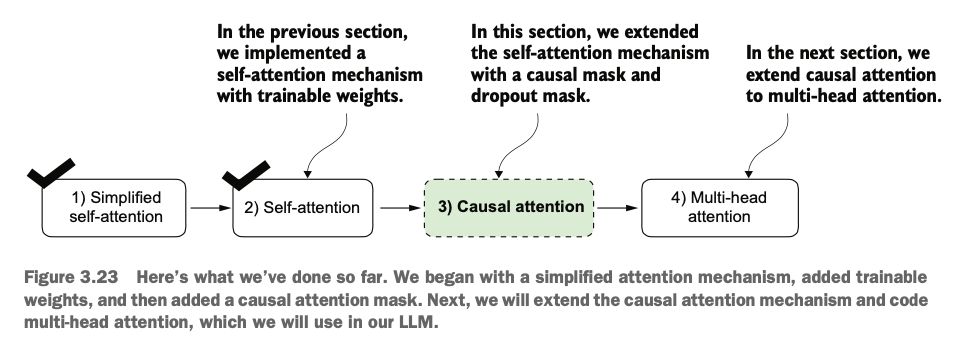